# CS 3500 - The Model 🧠

## Import Libraries 📚

In [16]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
import sys

device = torch.device("cpu")  # CPU only

sys.path.append('../bolt-job')
from run import Model

## Read-In And Examine Cleaned Dataset 👀

In [17]:
combined_df = pd.read_csv('../Data/Clean/Clean_Combined.csv')

# Split Data
def split_data(df, n_test=0.2, shuffle=True):
    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    test_size = int(n_test * len(df))
    train_size = len(df) - test_size

    train = df[:train_size]
    test = df[train_size:]
    return train, test

train, test = split_data(combined_df)
print("Length Of Train", len(train))
print("Length Of Test", len(test))

Length Of Train 189451
Length Of Test 47362


In [18]:
# Forgot to drop mo_codes --> Drop mo_codes as data has been extracted
train.drop(columns = "mo_codes", axis = 1, inplace = True)
train.head()

,DR_NO,area_code,reporting_district,crime_part,crime_code,victim_age,premise_code,weapon_code,days_to_holiday,report_year,...,occ_time_interval_06:01-12:00,occ_time_interval_12:01-18:00,occ_time_interval_18:01-24:00,occurrence_time_of_day_Afternoon,occurrence_time_of_day_Early Morning,occurrence_time_of_day_Evening,occurrence_time_of_day_Late Night,occurrence_time_of_day_Morning,occurrence_time_of_day_Night,Status
0,231911685,19,1959,1,331,48,101.0,0.0,8,2023,...,False,False,True,False,False,False,False,False,True,1
1,232018937,20,2026,1,230,26,101.0,302.0,10,2023,...,False,False,False,False,False,False,True,False,False,1
2,240408251,4,412,1,330,27,504.0,0.0,19,2024,...,False,False,True,False,False,False,False,False,True,1
3,231910450,19,1974,2,930,35,502.0,511.0,14,2023,...,False,False,True,False,False,False,False,False,True,0
4,230306036,3,375,2,354,50,501.0,0.0,17,2023,...,False,False,False,False,False,False,True,False,False,1


In [19]:
test.drop(columns = "mo_codes", axis = 1, inplace = True)
test.head()

,DR_NO,area_code,reporting_district,crime_part,crime_code,victim_age,premise_code,weapon_code,days_to_holiday,report_year,...,occ_time_interval_06:01-12:00,occ_time_interval_12:01-18:00,occ_time_interval_18:01-24:00,occurrence_time_of_day_Afternoon,occurrence_time_of_day_Early Morning,occurrence_time_of_day_Evening,occurrence_time_of_day_Late Night,occurrence_time_of_day_Morning,occurrence_time_of_day_Night,Status
189451,230107790,1,155,2,626,46,502.0,400.0,7,2023,...,False,True,False,False,False,True,False,False,False,1
189452,230915076,9,985,1,330,40,101.0,0.0,2,2023,...,False,True,False,False,False,True,False,False,False,1
189453,230905250,9,923,2,664,80,102.0,0.0,15,2023,...,False,False,True,False,False,True,False,False,False,1
189454,231312969,13,1331,1,230,53,101.0,106.0,6,2023,...,False,False,False,False,False,False,True,False,False,1
189455,231318728,13,1317,2,624,19,935.0,400.0,1,2023,...,False,True,False,True,False,False,False,False,False,1


In [20]:
train.info() # All datatypes float, int, boolean --> We are now able to move on

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189451 entries, 0 to 189450
Columns: 604 entries, DR_NO to Status
dtypes: bool(563), float64(2), int64(39)
memory usage: 161.0 MB


## Define Features/Target And Perform Light Preprocessing ♻️
* We Are Scaling Features since the dataset contains 0 values to values in the millions! This can affect the performance of our model.
   

In [21]:
# Define target and features - Train
train_features = train.drop(columns="Status")
train_target = train["Status"]

# Define target and features - Test
test_features = test.drop(columns="Status")
test_target = test["Status"]

# Scale Features
feature_scaler = PowerTransformer(method='yeo-johnson')
scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_test_features = feature_scaler.fit_transform(test_features)

## Create DataLoaders (*Convert Pandas DF To Tensors*) ⚙️

In [22]:
class Crime_Dataset(Dataset):
    def __init__(self, features, targets):
        # Conver to Torch Tensors
        self.x = torch.tensor(features, dtype = torch.float32)
        self.y = torch.tensor(targets.values, dtype = torch.float32)

    # Define mandatory length method
    def __len__(self):
        return len(self.y)
    
    # Define mandatory get item method
    def __getitem__(self, index):
        return self.x[index], self.y[index]

# Instantiate Class With Data
train_df = Crime_Dataset(scaled_train_features, train_target)
test_df = Crime_Dataset(scaled_test_features, test_target)

test_loader = DataLoader(test_df, batch_size=32, shuffle=False)

In [23]:
model = Model()
model.load_state_dict(torch.load('../bolt-job/model_final.pt', map_location=device))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = torch.sigmoid(model(X_batch))
        preds = (outputs > 0.5).long().squeeze(1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

print(classification_report(all_labels, all_preds, digits=4))

for i in range(5):
    print(f"Prediction: {all_preds[i]} \t Actual: {all_labels[i]}")

/var/folders/c8/8kf2c39x4599l74dmxjryfvw0000gn/T/ipykernel_56005/4026039419.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../bolt-job

              precision    recall  f1-score   support

         0.0     0.9697    0.8317    0.8954      3767
         1.0     0.9856    0.9978    0.9917     43595

    accuracy                         0.9845     47362
   macro avg     0.9777    0.9147    0.9435     47362
weighted avg     0.9844    0.9845    0.9840     47362

Prediction: 1 	 Actual: 1.0
Prediction: 1 	 Actual: 1.0
Prediction: 1 	 Actual: 1.0
Prediction: 1 	 Actual: 1.0
Prediction: 1 	 Actual: 1.0


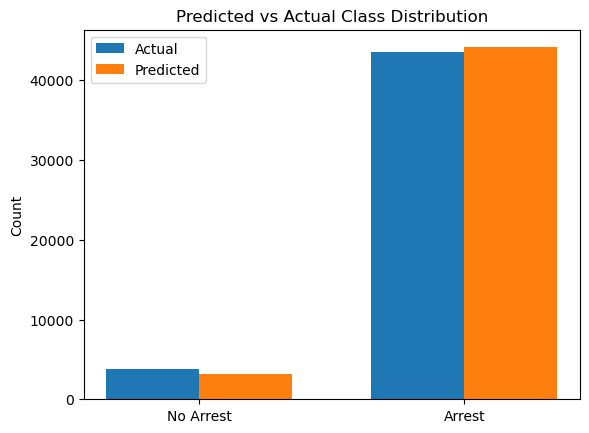

In [24]:
import matplotlib.pyplot as plt

unique_labels = ['No Arrest', 'Arrest']
pred_counts = [all_preds.count(0), all_preds.count(1)]
actual_counts = [all_labels.count(0), all_labels.count(1)]

x = np.arange(len(unique_labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, actual_counts, width, label='Actual')
ax.bar(x + width/2, pred_counts, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Predicted vs Actual Class Distribution')
ax.set_xticks(x)
ax.set_xticklabels(unique_labels)
ax.legend()

plt.show()

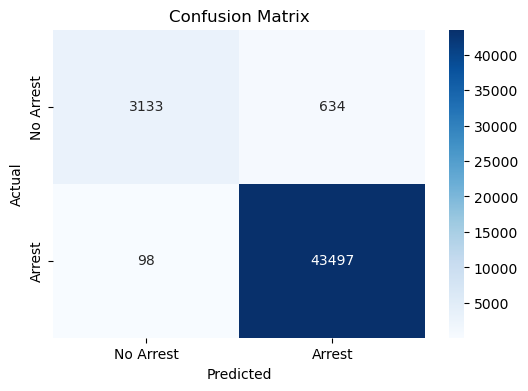

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No Arrest', 'Arrest'], yticklabels=['No Arrest', 'Arrest'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

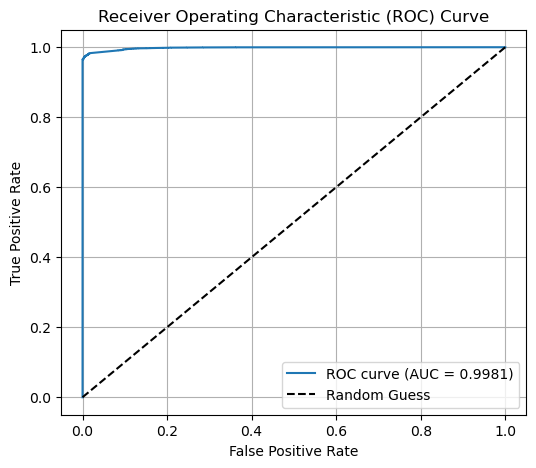

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Collect probabilities and true labels
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = torch.sigmoid(model(X_batch))  # probabilities
        all_probs.extend(outputs.squeeze(1).numpy())
        all_labels.extend(y_batch.numpy())


fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

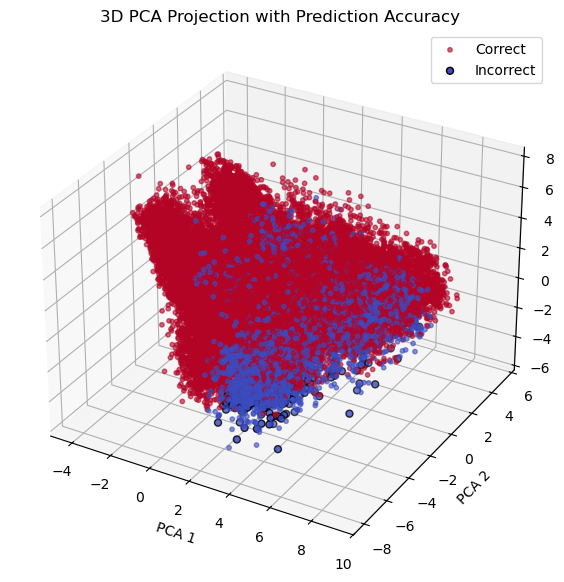

In [32]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 3D
pca_3d = PCA(n_components=4)
X_pca_3d = pca_3d.fit_transform(scaled_test_features)

# Get actuals and predicted
actuals = np.array(test_target)
with torch.no_grad():
    probs = torch.sigmoid(model(torch.tensor(scaled_test_features, dtype=torch.float32)))
    preds = (probs > 0.5).long().squeeze(1).numpy()
correct = preds == actuals

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Correct predictions
ax.scatter(X_pca_3d[correct, 0], X_pca_3d[correct, 1], X_pca_3d[correct, 2],
           c=actuals[correct], cmap='coolwarm', s=10, label='Correct', alpha=0.6)

# Incorrect predictions
ax.scatter(X_pca_3d[~correct, 0], X_pca_3d[~correct, 1], X_pca_3d[~correct, 2],
           c=actuals[~correct], cmap='coolwarm', edgecolors='k', s=25, label='Incorrect')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('3D PCA Projection with Prediction Accuracy')
ax.legend()
plt.show()